# 0. Setup Paths

In [11]:
import os

In [12]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [13]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [14]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [15]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [16]:
# https://www.tensorflow.org/install/source_windows

In [6]:
if os.name=='nt':
    !pip install wget
    import wget

In [8]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [9]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

100% [..........................................................................] 1468733 / 1468733        1 file(s) moved.
        1 file(s) copied.


zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.densepose_ops.cpython-37: module references __file__
object_detection.core.__pycache__.preprocessor.cpython-37: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-37: module MAY be using inspect.stack
zip_safe flag not set; analyzing archive contents...
zip_safe flag not set; analyzing archive contents...
cpuinfo.__pycache__.cpuinfo.cpython-37: module references __file__
zip_safe flag not set; analyzing archive contents...
error: numpy 1.20.2 is installed but numpy<1.20.0,>=1.14.3 is required by {'apache-beam'}


running build
running build_py
copying object_detection\protos\anchor_generator_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\argmax_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\bipartite_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_predictor_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\calibration_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\center_net_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\eval_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\flexible_grid_anchor_generator_pb2.py -> 

Obtaining file:///D:/YouTube/23-03-2021%20-%20OD%20Full%20Course/TFODCourse/Tensorflow/models/research/slim
  Attempting uninstall: slim
    Found existing installation: slim 0.1
    Uninstalling slim-0.1:
      Successfully uninstalled slim-0.1
  Running setup.py develop for slim


In [17]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2021-04-01 12:44:26.617418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
Running tests under Python 3.7.3: D:\YouTube\23-03-2021 - OD Full Course\TFODCourse\tfod\Scripts\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-04-01 12:44:32.882680: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-01 12:44:32.883517: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-01 12:44:32.907835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-01 12:44:32.907859: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic li

I0401 12:44:40.781724 17044 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 288
I0401 12:44:40.782724 17044 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet BiFPN num iterations: 7
I0401 12:44:40.784723 17044 efficientnet_model.py:147] round_filter input=32 output=48
I0401 12:44:40.794725 17044 efficientnet_model.py:147] round_filter input=32 output=48
I0401 12:44:40.794725 17044 efficientnet_model.py:147] round_filter input=16 output=24
I0401 12:44:40.904267 17044 efficientnet_model.py:147] round_filter input=16 output=24
I0401 12:44:40.904267 17044 efficientnet_model.py:147] round_filter input=24 output=40
I0401 12:44:41.134267 17044 efficientnet_model.py:147] round_filter input=24 output=40
I0401 12:44:41.134267 17044 efficientnet_model.py:147] round_filter input=40 output=64
I0401 12:44:41.364267 17044 efficientnet_model.py:147] round_filter input=40 output=64
I0401 12:44:41.364267 17044 efficientnet_model.py:147] round_filter input=80 

In [14]:
!pip install tensorflow --upgrade

  Using cached google-3.0.0-py2.py3-none-any.whl (45 kB)
  Using cached beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Using cached soupsieve-2.2.1-py3-none-any.whl (33 kB)


In [31]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

Found existing installation: protobuf 3.15.6
Uninstalling protobuf-3.15.6:
  Successfully uninstalled protobuf-3.15.6
Found existing installation: matplotlib 3.4.0
Uninstalling matplotlib-3.4.0:
  Successfully uninstalled matplotlib-3.4.0
  Using cached protobuf-3.15.6-cp37-cp37m-win_amd64.whl (904 kB)
  Using cached matplotlib-3.2.0-cp37-cp37m-win_amd64.whl (9.2 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.28.0 requires crcmod<2.0,>=1.7, which is not installed.
apache-beam 2.28.0 requires dill<0.3.2,>=0.3.1.1, which is not installed.
apache-beam 2.28.0 requires fastavro<2,>=0.21.4, which is not installed.
apache-beam 2.28.0 requires future<1.0.0,>=0.18.2, which is not installed.
apache-beam 2.28.0 requires hdfs<3.0.0,>=2.1.0, which is not installed.
apache-beam 2.28.0 requires httplib2<0.18.0,>=0.8, which is not installed.
apache-beam 2.28.0 requires mock<3.0.0,>=1.0.1, which is not installed.
tensorflow-datasets 4.2.0 requires attrs>=18.1.0, which is not installed.
tensorflow-datasets 4.2.0 requires dill, which is not installed.
tensorflow-datasets 4.2.0 requires future, which is not installed.
tensorflow-datasets 4.2.0 requires importlib-resources, which is not installed.
tensorflow-datasets 4.2.0 re

In [16]:
import object_detection

In [10]:
!pip list

Package                       Version     Location
----------------------------- ----------- ---------------------------------------------------------------------------------
absl-py                       0.12.0
apache-beam                   2.28.0
astunparse                    1.6.3
avro-python3                  1.10.2
backcall                      0.2.0
beautifulsoup4                4.9.3
cachetools                    4.2.1
certifi                       2020.12.5
chardet                       4.0.0
colorama                      0.4.4
contextlib2                   0.6.0.post1
cycler                        0.10.0
cython                        3.0a6
dataclasses                   0.8
decorator                     4.4.2
flatbuffers                   1.12
gast                          0.3.3
gin-config                    0.4.0
google                        3.0.0
google-api-python-client      2.0.2
google-auth                   1.28.0
google-auth-oauthlib          0.4.4
google-cloud-bigquery

## RESTART KERNEL TO PICKUP NEWLY INSTALLED LIBS

In [11]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

100% [........................................................................] 20515344 / 20515344        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


# 2. Create Label Map

In [19]:
labels = [{'name':'Hello', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [20]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

x Tensorflow/workspace/images/train/
x Tensorflow/workspace/images/train/hello.a815bb5a-91c4-11eb-b6bf-5cf3709bbcc6.jpg
x Tensorflow/workspace/images/train/hello.a815bb5a-91c4-11eb-b6bf-5cf3709bbcc6.xml
x Tensorflow/workspace/images/train/hello.a94f6b7a-91c4-11eb-b15d-5cf3709bbcc6.jpg
x Tensorflow/workspace/images/train/hello.a94f6b7a-91c4-11eb-b15d-5cf3709bbcc6.xml
x Tensorflow/workspace/images/train/hello.aa829f4a-91c4-11eb-a15e-5cf3709bbcc6.jpg
x Tensorflow/workspace/images/train/hello.aa829f4a-91c4-11eb-a15e-5cf3709bbcc6.xml
x Tensorflow/workspace/images/train/hello.abb6f9e8-91c4-11eb-bad9-5cf3709bbcc6.jpg
x Tensorflow/workspace/images/train/hello.abb6f9e8-91c4-11eb-bad9-5cf3709bbcc6.xml
x Tensorflow/workspace/images/train/hello.aced7e0c-91c4-11eb-bf9c-5cf3709bbcc6.jpg
x Tensorflow/workspace/images/train/hello.aced7e0c-91c4-11eb-bf9c-5cf3709bbcc6.xml
x Tensorflow/workspace/images/train/hello.ae2296e8-91c4-11eb-b4ab-5cf3709bbcc6.jpg
x Tensorflow/workspace/images/train/hello.ae2296e8

In [14]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow\scripts'...


In [21]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [22]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [23]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [29]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [30]:
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [26]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [27]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [28]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [31]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [32]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [33]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000


In [ ]:
!{command}

# 7. Evaluate the Model

In [32]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [33]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [6]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [7]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [8]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [10]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'hello.b1c12dc2-91c4-11eb-8963-5cf3709bbcc6.jpg')

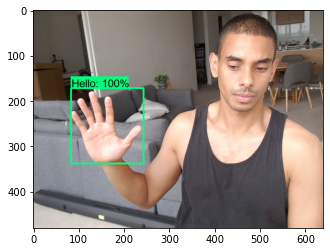

In [12]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Real Time Detections from your Webcam

In [18]:
!pip uninstall opencv-python-headless -y

Found existing installation: opencv-python-headless 4.5.1.48
Uninstalling opencv-python-headless-4.5.1.48:
  Successfully uninstalled opencv-python-headless-4.5.1.48


ERROR: Exception:
Traceback (most recent call last):
  File "d:\youtube\23-03-2021 - od full course\tfodcourse\tfod\lib\site-packages\pip\_internal\cli\base_command.py", line 189, in _main
    status = self.run(options, args)
  File "d:\youtube\23-03-2021 - od full course\tfodcourse\tfod\lib\site-packages\pip\_internal\commands\uninstall.py", line 91, in run
    uninstall_pathset.commit()
  File "d:\youtube\23-03-2021 - od full course\tfodcourse\tfod\lib\site-packages\pip\_internal\req\req_uninstall.py", line 456, in commit
    self._moved_paths.commit()
  File "d:\youtube\23-03-2021 - od full course\tfodcourse\tfod\lib\site-packages\pip\_internal\req\req_uninstall.py", line 296, in commit
    save_dir.cleanup()
  File "d:\youtube\23-03-2021 - od full course\tfodcourse\tfod\lib\site-packages\pip\_internal\utils\temp_dir.py", line 205, in cleanup
    rmtree(ensure_text(self._path))
  File "d:\youtube\23-03-2021 - od full course\tfodcourse\tfod\lib\site-packages\pip\_vendor\retrying.py",

In [11]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

KeyboardInterrupt: 

# 10. Freezing the Graph

In [34]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [35]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [36]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [37]:
!{command}

2021-04-01 13:44:20.891097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-01 13:44:23.477024: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-01 13:44:23.478097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-01 13:44:23.507550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-01 13:44:23.507574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-01 13:44:23.512298: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

# 11. Conversion to TFJS

In [38]:
!pip install tensorflowjs

In [39]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [40]:
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default Tensorflow\workspace\models\my_ssd_mobnet\export\saved_model Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport


In [41]:
!{command}

Writing weight file Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport\model.json...


2021-04-01 13:44:59.370610: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-01 13:45:02.409190: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-01 13:45:02.410117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-01 13:45:02.438516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-01 13:45:02.438542: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-01 13:45:02.443388: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

In [42]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [43]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [44]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [45]:
print(command)

python Tensorflow\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport


In [46]:
!{command}

2021-04-01 13:45:22.736268: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-01 13:45:25.299800: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-01 13:45:25.300737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-01 13:45:25.323536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-01 13:45:25.323561: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-01 13:45:25.332276: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

W0401 13:45:32.998846 10036 save_impl.py:78] Skipping full serialization of Keras layer <tensorflow.python.keras.layers.core.Lambda object at 0x00000206543C5668>, because it is not built.
W0401 13:45:32.998846 10036 save_impl.py:78] Skipping full serialization of Keras layer <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x00000206543C58D0>, because it is not built.
W0401 13:45:32.998846 10036 save_impl.py:78] Skipping full serialization of Keras layer <tensorflow.python.keras.layers.core.Lambda object at 0x00000206543C5F98>, because it is not built.
W0401 13:45:32.998846 10036 save_impl.py:78] Skipping full serialization of Keras layer <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x00000206543C5D30>, because it is not built.
W0401 13:45:32.998846 10036 save_impl.py:78] Skipping full serialization of Keras layer <tensorflow.python.keras.layers.core.Lambda object at 0x00000206543C5080>, because it is not built.
W0401 13:45:32.998846 

In [47]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [48]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [49]:
print(command)

tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [50]:
!{command}

2021-04-01 13:45:55.539007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-01 13:45:58.017673: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-01 13:45:58.018726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-01 13:45:58.041120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-01 13:45:58.041150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-01 13:45:58.050149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')